# Automatic Apparent Age Estimation
This notebook presents an exercise on debiasing age estimation. The goal is to experiment with various methods of training the model in order to check their impact on the training course. 



In [1]:
import pathlib
import pickle
import zipfile

import h5py
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.layers import (
    BatchNormalization, Dense, Dropout, Flatten)
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam, RMSprop
# from tensorflow.keras.applications.vgg16 import VGG16

## Helper functions

In [2]:
# Dataset load and preprocess.
def load_data(stage: str):
    return (
        np.load(f'./data/data_{stage}.npy'),
        np.load(f'./data/labels_{stage}.npy'),
        np.load(f'./data/meta_data_{stage}.npy'),
    )

def preprocess_X(X) -> None:
    """Preprocess samples so they can be used as
     ResNET50 inputs."""
    for i in range(0, X.shape[0]):
        x = X[i,:,:,:]
        x = np.expand_dims(x, axis=0)
        X[i,] = preprocess_input(x)

In [3]:
# Training and model evalueation.
def plot_train_history(train_history):
    """Plot learnign curves from the training history."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
    fig.suptitle('Training history (stage 1)', fontsize=14, fontweight='bold')

    ax1.plot(train_history['loss'])
    ax1.plot(train_history['val_loss'])
    ax1.set(xlabel='epoch', ylabel='LOSS')
    ax1.legend(['train', 'valid'], loc='upper right')

    ax2.plot(train_history['mae'])
    ax2.plot(train_history['val_mae'])
    ax2.set(xlabel='epoch', ylabel='MAE')
    ax2.legend(['train', 'valid'], loc='upper right')
    plt.show()

In [4]:
def evaluate_model(model: Model):
    predictions = model.predict(X_test, batch_size=32, verbose=1)

    # evaluating on test data
    predictions_f = predictions*100
    error = []
    for i in range(len(Y_test)):
        error.append(
            abs(np.subtract(predictions_f[i][0], Y_test[i])),
        )
    print(f'MAE = {np.mean(error):.8f}')
    return predictions_f

# Downloading and decompressing the Appa-Real Age Dataset [(source)](http://chalearnlap.cvc.uab.es/challenge/13/track/13/description/)


In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
root_dir = pathlib.Path('/content/gdrive/MyDrive/UPS/ComputerVision/simple_runs')

In [9]:
if not pathlib.Path(root_dir / 'app_data.zip').exists():
    !wget https://data.chalearnlap.cvc.uab.cat/Colab_2021/app_data.zip

with zipfile.ZipFile(root_dir / 'app_data.zip','r') as zip_file:
    zip_file.extractall()
    print('Data decompressed successfully')

# !rm app_data.zip

Data decompressed successfully


# Loading the dataset.

In [10]:
# loading the train data
X_train, Y_train, M_train = load_data('train')
# loading the validation data
X_valid, Y_valid, M_valid  = load_data('valid')
# loading the test data
X_test, Y_test, M_test = load_data('test')

# train labels are real numbers, ranging from ~0.9 to ~89 (years old);
# we will re-scale the labels to [0,1] by using a normalization factor of 100,
# assuming there is no sample with age > 100.
Y_train, Y_valid = Y_train/100, Y_valid/100

# Transform the dataset so it works with the ResNet.
preprocess_X(X_train)
preprocess_X(X_valid)
preprocess_X(X_test)

print(f"Train set ::: X : {X_train.shape}, "
      f"Y : {Y_train.shape}, M : {M_train.shape}")
print(f"Valid set ::: X : {X_valid.shape}, "
      f"Y : {Y_valid.shape}, M : {M_valid.shape}")
print(f"Test set ::: X : {X_test.shape}, "
      f"Y : {Y_test.shape}, M : {M_test.shape}")

Train set ::: X : (4065, 224, 224, 3), Y : (4065,), M : (4065, 3)
Valid set ::: X : (1482, 224, 224, 3), Y : (1482,), M : (1482, 3)
Test set ::: X : (1978, 224, 224, 3), Y : (1978,), M : (1978, 3)


---
# Dataset visualizations

### Visualizing the age distribution of Train data

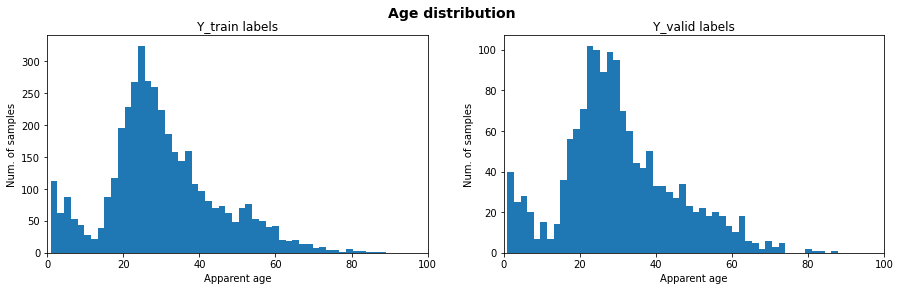

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Age distribution', fontsize=14, fontweight='bold')

# labels are multiplied by 100 to show the original values
ax1.hist(Y_train*100, bins = 50)
ax1.set_title('Y_train labels')
ax1.set(xlabel='Apparent age', ylabel='Num. of samples')
ax1.set_xlim([0, 100])

ax2.hist(Y_valid*100, bins = 50)
ax2.set_title('Y_valid labels')
ax2.set(xlabel='Apparent age', ylabel='Num. of samples')
ax2.set_xlim([0, 100])
plt.show()

### Visualizing the distributions of metadata (Train data)

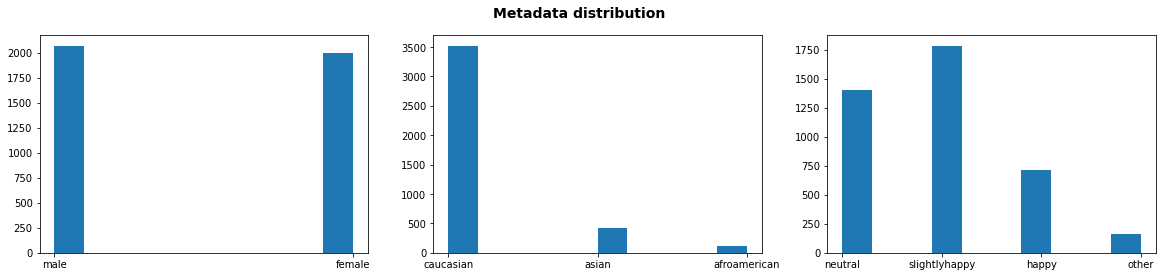

In [12]:
gender = []
etnhicity = []
emotion = []
for sample in M_train:
    gender.append(sample[0])
    etnhicity.append(sample[1])
    emotion.append(sample[2])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
fig.suptitle('Metadata distribution', fontsize=14, fontweight='bold')

ax1.hist(gender)
ax2.hist(etnhicity)
ax3.hist(emotion)
plt.show()

### Visualizing the age distribution per Ethnicity

In [13]:
def compute_hist_per_ethnicity(y_data, metadata, label):
    age_per_eth = {
        'asian': [],
        'afroamerican': [],
        'caucasian': [],
    }
    for meta, y in zip(metadata, y_data):
        age_per_eth[meta[1]].append(y)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
    fig.suptitle(f'Age distribution per Ethnicity {label}',
                 fontsize=14, fontweight='bold')

    ax1.hist(age_per_eth['asian'], bins=50)
    ax1.set_xlim([0, 100])
    ax1.set(xlabel='Asian', ylabel='Num. of samples')

    ax2.hist(age_per_eth['afroamerican'], bins=50)
    ax2.set_xlim([0, 100])
    ax2.set(xlabel='Afroamerican', ylabel='Num. of samples')

    ax3.hist(age_per_eth['caucasian'], bins=50) 
    ax3.set_xlim([0, 100])
    ax3.set(xlabel='Caucasian', ylabel='Num. of samples')
    plt.show()

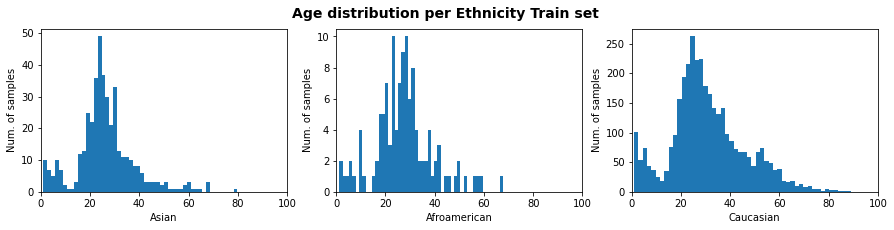

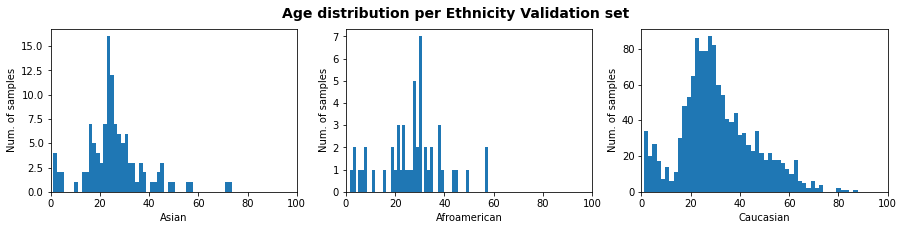

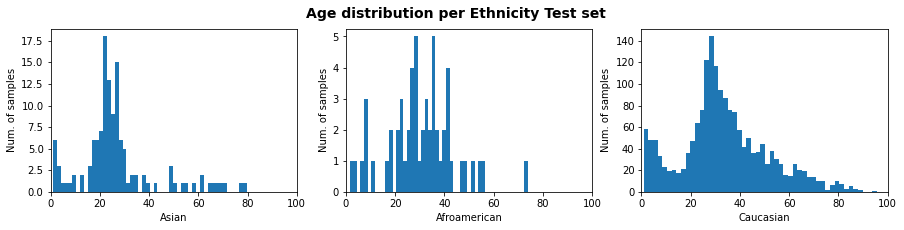

In [14]:
compute_hist_per_ethnicity(Y_train*100, M_train, 'Train set')
compute_hist_per_ethnicity(Y_valid*100, M_valid, 'Validation set')
compute_hist_per_ethnicity(Y_test, M_test, 'Test set')

# Downloading and loading ResNet50 model

In [17]:
# downloading the data
if not pathlib.Path(root_dir / 'model.zip').exists():
    !wget https://data.chalearnlap.cvc.uab.cat/Colab_2021/model.zip

# decompressing the data
with zipfile.ZipFile(root_dir / 'model.zip','r') as zip_file:
    zip_file.extractall()
    print('Model decompressed successfully')

model = tf.keras.models.load_model('./model/weights.h5')

Model decompressed successfully


# Base model definition.

In [18]:
# Get the flatten 2048 layer output from ResNet50 model.
flatten = model.get_layer('flatten_1').output #2048

# Dense layer + Batch Normalization + Dropout
fc_200 = Dense(200, activation='relu', name='f_200')(flatten)
batch_norm = BatchNormalization()(fc_200)
dp_layer = Dropout(0.4)(batch_norm)

# Dense layer + Dropout
fc_30 = Dense(30, activation='relu', name='f_30')(dp_layer)
dp_layer_2 = Dropout(0.3)(fc_30)

# Includint an additional FC layer with sigmoid activation, used to regress
# the apparent age
output = Dense(1, activation='sigmoid', name='predict')(dp_layer_2)

model = Model(
    inputs=model.get_layer('base_input').output, 
    outputs=output,
)
# print(model.summary())

# Train the Model  ::: Strategy 1
In this step, only a number of end layer will be enabled for training. The rest of the layers will keep their parameters and the gradient will have no impact on them. This is an example of transfer learning where we expect that the network already posses "domain knowledge" and we only aim to train the last layers that are specialized on a specific task - aparent age estimation in this example. Having the output of the _flatten_ layer that returns a vector of features we employ fully connected layer to perform a regression.

In [19]:
for counter, layer in enumerate(model.layers):
    layer.trainable = (counter > 174)

# Early stopping criterion.
es = EarlyStopping(
    monitor='val_mae', 
    mode='min', 
    verbose=1, 
    patience=7,
)
# Saving the best model based on val_loss.
mc = ModelCheckpoint(
    'model_checkpoint.h5', 
    monitor='val_mae',
    mode='min', 
    save_best_only=True,
)
# Reduce learning rate if loss is not decreasing.
rp = ReduceLROnPlateau(
    factor=0.1,
    patience=4,
    min_lr=1e-5,
    verbose=1
)
# Optimizer.
optim = RMSprop(learning_rate=1e-4)
# Loss function. 
loss = MeanSquaredError()

# Compile the model.
model.compile(
    optim,
    loss=loss,
    metrics=['mae'],
)

# Train the model.
history = model.fit(
    X_train, 
    Y_train, 
    validation_data=(X_valid, Y_valid),
    batch_size=64, 
    epochs=30,
    shuffle=True, 
    verbose=1, 
    callbacks=[es, mc, rp],
)

# Saving training history (for future visualization).
with open('train_history.pkl', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

Epoch 1/30
64/64 [==============================] - 32s 236ms/step - loss: 0.2508 - mae: 0.2142 - val_loss: 0.2101 - val_mae: 0.1443 - lr: 1.0000e-04
Epoch 2/30
64/64 [==============================] - 13s 200ms/step - loss: 0.2333 - mae: 0.1876 - val_loss: 0.2076 - val_mae: 0.1384 - lr: 1.0000e-04
Epoch 3/30
64/64 [==============================] - 13s 202ms/step - loss: 0.2274 - mae: 0.1784 - val_loss: 0.2053 - val_mae: 0.1328 - lr: 1.0000e-04
Epoch 4/30
64/64 [==============================] - 13s 204ms/step - loss: 0.2240 - mae: 0.1723 - val_loss: 0.2041 - val_mae: 0.1297 - lr: 1.0000e-04
Epoch 5/30
64/64 [==============================] - 13s 208ms/step - loss: 0.2193 - mae: 0.1645 - val_loss: 0.2020 - val_mae: 0.1238 - lr: 1.0000e-04
Epoch 6/30
64/64 [==============================] - 13s 208ms/step - loss: 0.2175 - mae: 0.1590 - val_loss: 0.2016 - val_mae: 0.1230 - lr: 1.0000e-04
Epoch 7/30
64/64 [==============================] - 13s 209ms/step - loss: 0.2149 - mae: 0.1524 - va

### Visualizing the train history

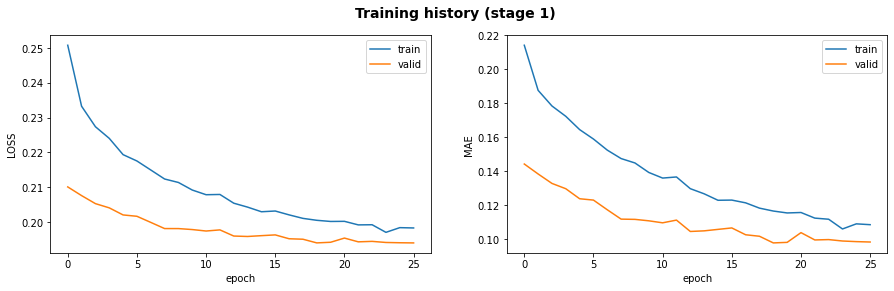

In [20]:
train_hist = pickle.load(open("train_history.pkl","rb"))
plot_train_history(train_hist)

### Loading the saved model and Evaluate on Test set

In [21]:
saved_model = load_model('model_checkpoint.h5')
_ = evaluate_model(saved_model)

62/62 [==============================] - 7s 87ms/step
MAE = 10.33084489


# Train the Model  ::: Strategy 2
After training the end layers of the model we would expect that they have adjusted their weights to the tast and now it is time to fine-tune the model. For that, all the layers will be able to adjust their weigths during the training to further minimize the error.

In [22]:
saved_model.trainable = True

# Early stopping criterion.
es = EarlyStopping(
    monitor='val_mae',
    mode='min', 
    verbose=1, 
    patience=10,
)
# Saving the best model based on val_loss.
mc = ModelCheckpoint(
    'model_checkpoint_2.h5', 
    monitor='val_mae', 
    mode='min', 
    save_best_only=True,
)
# Reduce learning rate if loss is not decreasing.
rp = ReduceLROnPlateau(
    monitor='val_mae',
    factor=0.5,
    patience=5,
    min_lr=1e-5,
    verbose=1
)

# Optimizer.
optim = Adam(learning_rate=1e-4)
saved_model.compile(
    optim,
    loss=loss,
    metrics=['mae'],
)

history = saved_model.fit(
    X_train, 
    Y_train, 
    validation_data=(X_valid, Y_valid), 
    batch_size=16, 
    epochs=30, 
    shuffle=True, 
    verbose=1, 
    callbacks=[es, mc, rp],
)

with open('train_history_2.pkl', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

Epoch 1/30
255/255 [==============================] - 59s 199ms/step - loss: 0.2086 - mae: 0.1362 - val_loss: 0.2356 - val_mae: 0.2002 - lr: 1.0000e-04
Epoch 2/30
255/255 [==============================] - 48s 187ms/step - loss: 0.1988 - mae: 0.1203 - val_loss: 0.2136 - val_mae: 0.1632 - lr: 1.0000e-04
Epoch 3/30
255/255 [==============================] - 48s 188ms/step - loss: 0.1911 - mae: 0.1116 - val_loss: 0.1817 - val_mae: 0.0897 - lr: 1.0000e-04
Epoch 4/30
255/255 [==============================] - 48s 187ms/step - loss: 0.1814 - mae: 0.1022 - val_loss: 0.1734 - val_mae: 0.0868 - lr: 1.0000e-04
Epoch 5/30
255/255 [==============================] - 48s 187ms/step - loss: 0.1728 - mae: 0.0974 - val_loss: 0.1930 - val_mae: 0.1656 - lr: 1.0000e-04
Epoch 6/30
255/255 [==============================] - 48s 187ms/step - loss: 0.1645 - mae: 0.0964 - val_loss: 0.1639 - val_mae: 0.1086 - lr: 1.0000e-04
Epoch 7/30
255/255 [==============================] - 46s 182ms/step - loss: 0.1581 - ma

### Visualizing the Training history of both stages

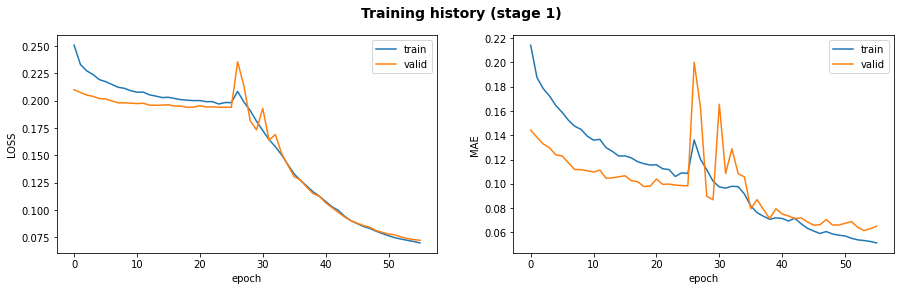

In [23]:
train_hist = pickle.load(open("train_history.pkl","rb"))
train_hist_2 = pickle.load(open("train_history_2.pkl","rb"))
total_history = {}
for key in ('loss', 'val_loss', 'mae', 'val_mae'):
    total_history[key] = train_hist[key] + train_hist_2[key]

plot_train_history(total_history)

In [24]:
saved_model_2 = load_model('model_checkpoint_2.h5')
predictions = evaluate_model(saved_model_2)

62/62 [==============================] - 5s 76ms/step
MAE = 7.15334879
